# Permeability Prediction of Core Samples

***
##Introduction
This is a little practice project I did to hone my skills in data analysis. I am still on a learning stage so bare with me. I have a background in petroleum engineering so it was great that I was able to find a dataset within my domain. 


The rock.csv file was obtained from Kaggle with no description from the uploader. Thus, I don't have any information about the methodology of measurement and specific units used in the dataset. I was continuously figuring out how to process the data throughout this whole project Again, bare with me. Thank you.

### Goal

In this simple study, we'll try to predict the Permeability of a Core Sample using the informations contained in the rock.csv dataset. The first part is focused on understanding the data and its variables using statistical analysis and visualization techniques. After that, I applied multiple linear regression using gradient descent and other algorithms that I am currently learning to execute in Python. Then, I will evaluate the different models established and decide which is the optimal choice to predict Permeability.

***
##Looking into the Data

In [20]:
# Installing necessary libraries
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### The dataset

In this section, I will look through and organize the dataset.

In [4]:
# Download and read 'rock.csv'
data_url = 'https://raw.githubusercontent.com/mavsison/core-sample-permeability-prediction/master/rock.csv'
download_url(data_url, '.')
data_filename = 'rock.csv'
pd.read_csv(data_filename).head()

Using downloaded and verified file: ./rock.csv


,Unnamed: 0,area,peri,shape,perm
0,1,4990,2791.90,0.090330,6.3
1,2,7002,3892.60,0.148622,6.3
2,3,7558,3930.66,0.183312,6.3
3,4,7352,3869.32,0.117063,6.3
4,5,7943,3948.54,0.122417,17.1


In [5]:
rock = pd.read_csv(data_filename) # store the csv file as 'rock' data frame

rock.info() # to know the dataset more

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  48 non-null     int64  
 1   area        48 non-null     int64  
 2   peri        48 non-null     float64
 3   shape       48 non-null     float64
 4   perm        48 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 2.0 KB


In [6]:
# Organizing the data frame
rock.rename(columns = {'area':'Area', 
                       'peri':'Perimeter', 
                       'shape':'Shape', 
                       'perm':'Permeability', 
                       'Unnamed: 0':'Core Samples'}, 
            inplace = True)
rock = rock[['Permeability', 'Shape', 'Area', 'Perimeter', 'Core Samples']]
rock.set_index('Core Samples', inplace = True)
rock.head(10)

,Permeability,Shape,Area,Perimeter
Core Samples,,,,
1,6.3,0.090330,4990,2791.90
2,6.3,0.148622,7002,3892.60
3,6.3,0.183312,7558,3930.66
4,6.3,0.117063,7352,3869.32
5,17.1,0.122417,7943,3948.54
6,17.1,0.167045,7979,4010.15
7,17.1,0.189651,9333,4345.75
8,17.1,0.164127,8209,4344.75
9,119.0,0.203654,8393,3682.04


In [7]:
# As per data information, 12 core samples was divided into four cross section to make this data set. To check this:

print('Unique permeabilities: ', rock.Permeability.unique())
print('\nNumber of cores: ', len(rock.Permeability.unique()))

Unique permeabilities:  [   6.3   17.1  119.    82.4   58.6  142.   740.   890.   950.   100.
 1300.   580. ]

Number of cores:  12


In [8]:
rock.describe() # to know basic statistical details of the data set

,Permeability,Shape,Area,Perimeter
count,48.000000,48.000000,48.000000,48.000000
mean,415.450000,0.218110,7187.729167,2682.211938
std,437.818226,0.083496,2683.848862,1431.661164
min,6.300000,0.090330,1016.000000,308.642000
25%,76.450000,0.162262,5305.250000,1414.907500
50%,130.500000,0.198862,7487.000000,2536.195000
75%,777.500000,0.262670,8869.500000,3989.522500
max,1300.000000,0.464125,12212.000000,4864.220000


The data set is fairly small with only 48 rows and 4 columns namely Permeability, Shape, Area, and Perimeter.


In [0]:
per_core = rock.groupby(rock['Permeability'], as_index=False).mean()

####Methodology

With these info, the analysis that will be done is with both per cross section data (48 rows) and per core data (12 rows, mean of four cross section)

***

### Analyze the data

Let us plot the correlation between each column and see its linear relationship.

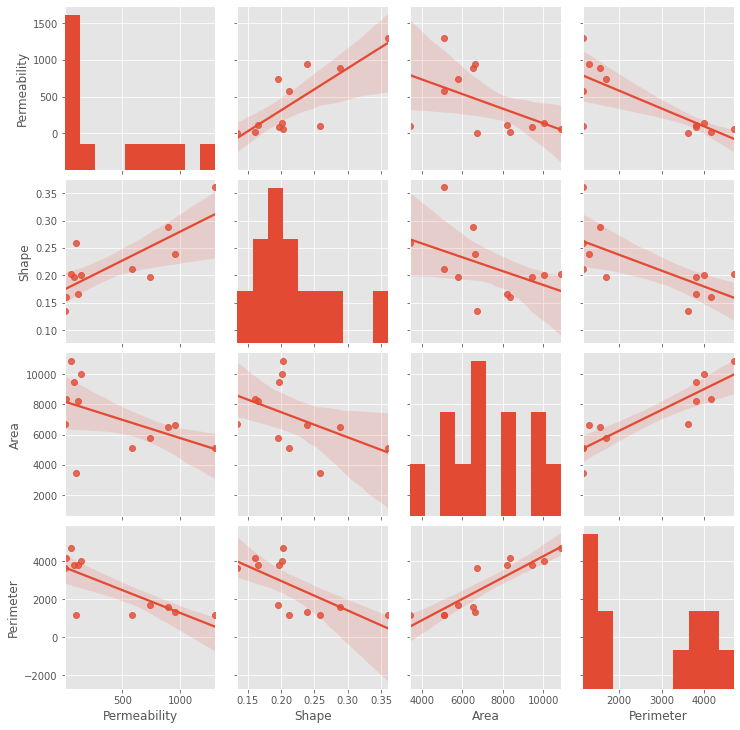

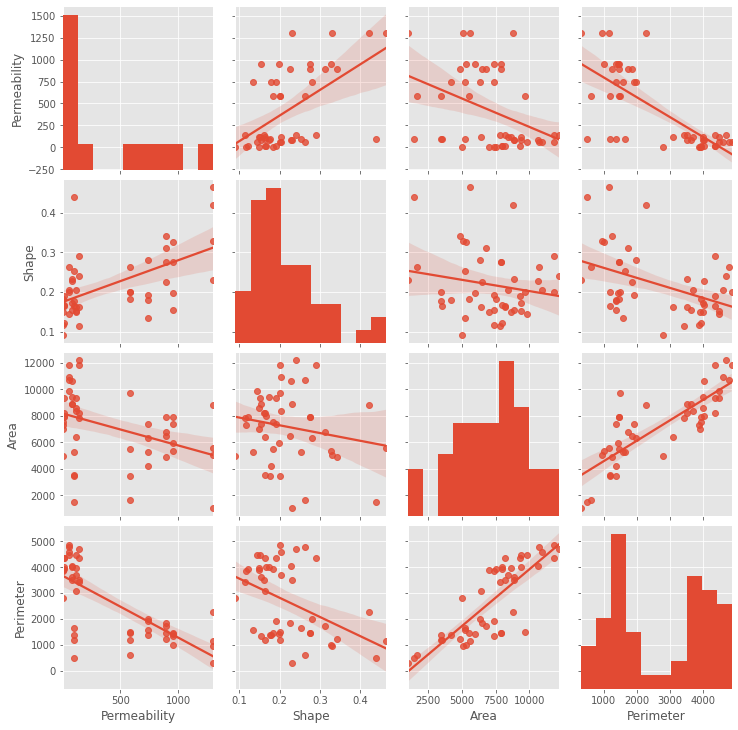

In [26]:
plt.style.use('ggplot')

sns.pairplot(per_core, kind='reg')
sns.pairplot(rock, kind='reg')

plt.show()

In [27]:
rock.corr()

,Permeability,Shape,Area,Perimeter
Permeability,1.000000,0.556721,-0.396637,-0.738716
Shape,0.556721,1.000000,-0.182161,-0.433126
Area,-0.396637,-0.182161,1.000000,0.822506
Perimeter,-0.738716,-0.433126,0.822506,1.000000


These plots show the linear correlation between each column. The correlation coefficient values suggest a not so strong linear correlation. 
1. 


I'll try getting the mean for each core sample to see if there'll be a difference. So 12 rows will be created.

It's interesting how the correlation coefficients became closer to 1 for positively correlated values (positive slope), and -1 for negatively correlated values (negative slope), especially for those correlated to pore shape factor. This is good since -1 and 1 values of correlation coefficient shows the strongest/exact linear correlation between two variables.


This can show that permeability values of the core that not solely rely on the property of the pores alone, but also the interconnection of those pores.

Let's see the changes in correlation coefficient.

In [28]:
abs(per_core.corr() - rock.corr())

,Permeability,Shape,Area,Perimeter
Permeability,0.000000,0.223120,0.096035,0.030171
Shape,0.223120,0.000000,0.276239,0.241242
Area,0.096035,0.276239,0.000000,0.061937
Perimeter,0.030171,0.241242,0.061937,0.000000


Using linear regression to model permeability don't 